# Assignment 3 — Monte Carlo DNA Volume & Accessible Volume 



- Course / Assignment: Assignment 3 (Deadline: 9. November, 23:59)
- Group Members: 


## Administrative


### Individual Contributions
_(Replace this with a brief breakdown if working in a group.)_
- Name A: ...
- Name B: ...
- Name C: ...


## Setup

> Install any missing packages in your environment first (e.g., `numpy`, `matplotlib`).

In [ ]:
# Standard imports — extend as needed
# (Do NOT implement task logic here; only imports and minimal config.)

import os
from math import isclose
import random
from typing import Tuple, Iterable, List
from project_lib import SimulationBox3D, random_sphere_in_box, Sphere, random_walkers_3D

# Numerical & plotting (if you use them)
import numpy as np
import matplotlib.pyplot as plt

# Project module (you write all logic here)
# from project_lib import (
#     # add your functions here as you implement them in project_lib.py
# )

# Optional: configure matplotlib defaults if desired
# plt.rcParams["figure.dpi"] = 120
# %matplotlib inline  # Uncomment if running locally in classic Jupyter

## Code Quality (Bonus)

- Run `pylint` on your `project_lib.py` for a bonus score (0–10 from pylint).
- Add `assert` statements in functions (up to +5).
- Add up to **5 test functions** (max +5).

In [55]:
# RELOAD BLOCK TO GET IMPORTS TO WORK
from importlib import reload
import project_lib
reload(project_lib)

from project_lib import (
    SimulationBox3D, Sphere,
    random_sphere_in_box,
    estimate_fraction_inside_sphere, run_pi_experiment,
    generate_random_spheres, create_sphere_from_dna_file,
    bounding_box_for_spheres, estimate_fraction_inside_spheres,
    random_walkers_3D, run_walkers_slow_fast, plot_walkers_subset
)
import matplotlib.pyplot as plt

# Set random seed for reproducibility
rng = np.random.default_rng(123)


# TOPIC 1: Calculate DNA Volume via Monte Carlo Simulation

## Task 0: Define your simulation box (x, y, z) dimensions in a 3D space

In [4]:

# Box ranges
x_range = (0.0, 100.0)
y_range = (0.0, 100.0)
z_range = (0.0, 100.0)

# Creating box with defined ranges
box = SimulationBox3D(x_range, y_range, z_range)

# Tests for box
print(box)
print(f"Volume of the box is: {box.volume()}") #print volume of box
assert isclose(box.volume(), 1000000)
print(f"Surface area of the box is: {box.surface_area()}")
assert isclose(box.surface_area(), 60000)
print("Assert checks on Geometry is ok!")


SimulationBox dimensions:
  x: (0.0, 100.0)
  y: (0.0, 100.0)
  z: (0.0, 100.0)
Volume of the box is: 1000000.0
Surface area of the box is: 60000.0
Assert checks on Geometry is ok!


## Task 1: Make a function to randomly position a point in your simulation box from a uniform distribution

In [5]:
# Using box from task 0: (x: (0.0, 100.0), y: (0.0, 100.0), z: (0.0, 100.0))

# Create 10 random points, assert they are inside the box, print them out
pts = box.random_point(n=10)
assert np.all((pts >= 0) & (pts <= 100))
for i, (x, y, z) in enumerate(pts, start=1):
    print(f"Point {i:2d}: ({x:.3f}, {y:.3f}, {z:.3f})")

#Uniformity check with 3000 points
pts = box.random_point(n=3000)     # shape (3000, 3)
x, y, z = pts[:,0], pts[:,1], pts[:,2]
mean_x = np.mean(x)
mean_y = np.mean(y)
mean_z = np.mean(z)

#Checks if mean is close to 50 with tolerance of 5%
assert all(isclose(m, 50, rel_tol=0.05) for m in (mean_x, mean_y, mean_z))
print("Points inbound and Uniformity check cleared!")


Point  1: (87.950, 96.548, 13.760)
Point  2: (58.529, 78.758, 11.181)
Point  3: (57.562, 7.212, 33.290)
Point  4: (83.858, 34.449, 2.325)
Point  5: (29.716, 34.654, 56.998)
Point  6: (49.149, 12.306, 26.032)
Point  7: (12.022, 71.960, 24.442)
Point  8: (22.863, 87.616, 74.284)
Point  9: (97.184, 93.601, 86.667)
Point 10: (91.193, 35.422, 84.602)
Points inbound and Uniformity check cleared!


## Task 2: Position a sphere in a random place and size in your simulation box

In [6]:
# Using box from task 0: (x: (0.0, 100.0), y: (0.0, 100.0), z: (0.0, 100.0))

# Sphere radius ranges
r_min = 2.0
r_max = 50.0
rng = np.random.default_rng(123)

# Create a sphere and assign center coordinates and radius to variables for testing
sphere = random_sphere_in_box(box, r_min=r_min, r_max=r_max, rng=rng)
c_x, c_y, c_z = sphere.center
r = sphere.radius

# Finding geometric limit of box
r_limit = 0.5 * min(box.xmax - box.xmin, box.ymax - box.ymin, box.zmax - box.zmin)

# Radius and center checks
assert r_min <= r <= min(r_max, r_limit), "Sampled radius out of allowed range."
assert (box.xmin + r) <= c_x <= (box.xmax - r), "Center x violates box margin."
assert (box.ymin + r) <= c_y <= (box.ymax - r), "Center y violates box margin."
assert (box.zmin + r) <= c_z <= (box.zmax - r), "Center z violates box margin."

print("Random sphere in a box:")
print(f"  center = ({c_x:.3f}, {c_y:.3f}, {c_z:.3f})")
print(f"  radius = {r:.3f}")
print("Radius and Center check asserts ok!")

Random sphere in a box:
  center = (36.394, 41.473, 40.375)
  radius = 34.753
Radius and Center check asserts ok!


## Task 3: Make a function that checks if a point is inside the sphere or not

In [7]:
# Assumptions: Points on sphere boundary does not count as inside.

# Create a sphere
sphere_test = Sphere(center =(0.0, 0.0, 0.0), radius=5.0)

# Checks for different points
assert sphere_test.is_point_in_sphere((0.0, 0.0, 0.0))           # center is inside
assert sphere_test.is_point_in_sphere((1.0, 2.0, 1.0))           # point inside
assert not sphere_test.is_point_in_sphere((5.0, 0.0, 0.0))       # on boundary: does not count as inside per our assumption
assert not sphere_test.is_point_in_sphere((6.0, 0.0, 0.0))       # outside
print("Sphere inside checks ok!")

Sphere inside checks ok!


## Task 4: Calculate and plot the fraction of points INSIDE the sphere divided by the number of randomly generated points. How do you check if your result is right?


We check and verify if the result is correct by comparing the Monte Carlo fraction of points inside the spheres to the analytical volume ratio between the sphere and simulation box:

$
\hat{p} = \frac{N_{\text{inside}}}{N_{\text{total}}}
\qquad \text{and} \qquad
p = \frac{V_{\text{sphere}}}{V_{\text{box}}}
= \frac{\frac{4}{3}\pi r^3}{L_x L_y L_z}
$

$\hat{p}$ should converge towards $p$ 
as the number of samples $N$ increases, within the statistical uncertainty

$
\sigma_{\hat{p}} = \sqrt{\frac{\hat{p}(1 - \hat{p})}{N}}.
$


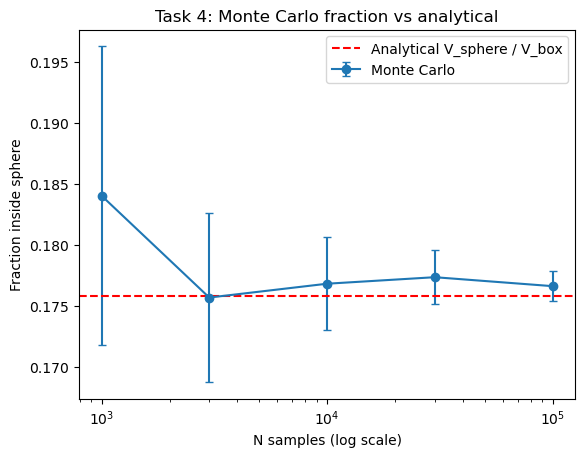

Analytical fraction: 0.175817
N=   1000  frac=0.184000  stderr≈0.012253
N=   3000  frac=0.175667  stderr≈0.006948
N=  10000  frac=0.176800  stderr≈0.003815
N=  30000  frac=0.177333  stderr≈0.002205
N= 100000  frac=0.176600  stderr≈0.001206


In [8]:
# 1) Make a simple box and one random sphere that fits inside

rng = np.random.default_rng(123)

# 2) Monte Carlo estimates at increasing N (to show convergence)
Ns = [1_000, 3_000, 10_000, 30_000, 100_000]
estimates = []
errors = []

for N in Ns:
    frac, err = estimate_fraction_inside_sphere(box, sphere, n_samples=N, rng=rng)
    estimates.append(frac)
    errors.append(err)

# 3) Analytical fraction for sanity check
expected = sphere.volume() / box.volume()

# 4) Plot
plt.figure()
plt.errorbar(Ns, estimates, yerr=errors, fmt="o-", capsize=3, label="Monte Carlo")
plt.axhline(expected, linestyle="--", label="Analytical V_sphere / V_box", color="red")
plt.xscale("log")
plt.xlabel("N samples (log scale)")
plt.ylabel("Fraction inside sphere")
plt.title("Task 4: Monte Carlo fraction vs analytical")
plt.legend()
plt.show()

print(f"Analytical fraction: {expected:.6f}")
for N, p, se in zip(Ns, estimates, errors):
    print(f"N={N:>7d}  frac={p:.6f}  stderr≈{se:.6f}")


## Task 5: Calculate pi as a function of the number of randomly generated points

In this task, random points were generated uniformly inside the same simulation 
box used in earlier tasks. Each point was tested to see whether it lies inside 
the sphere, and the fraction of points inside was computed as

$
p = \frac{N_{\text{inside}}}{N_{\text{total}}}
\approx
\frac{V_{\text{sphere}}}{V_{\text{box}}}
= \frac{\tfrac{4}{3}\pi r^3}{V_{\text{box}}}
$

Solving for $\pi$ gives the Monte Carlo estimator

$
\hat{\pi} = \frac{3\,p\,V_{\text{box}}}{4\,r^3}
$

If the implementation is correct, $\hat{\pi}$ should converge toward the true 
value of $\pi \approx 3.14159$ as the number of samples $N$ increases, within 
the expected statistical uncertainty

$
\sigma_{\hat{\pi}} =
\frac{3\,V_{\text{box}}}{4\,r^3}
\sqrt{\frac{p(1 - p)}{N}}
$

Convergence was verified by plotting $\hat{\pi}$ as a function of $N$ and 
confirming that it stabilizes around $\pi$ with decreasing error bars.

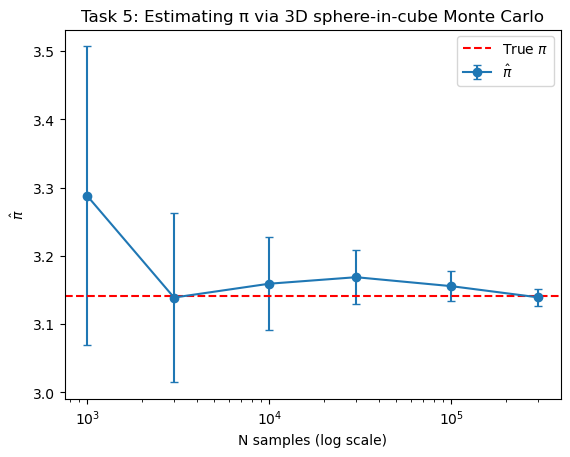

N=    1000  pi_hat=3.287807  stderr≈0.218949
N=    3000  pi_hat=3.138903  stderr≈0.124144
N=   10000  pi_hat=3.159154  stderr≈0.068168
N=   30000  pi_hat=3.168684  stderr≈0.039404
N=  100000  pi_hat=3.155580  stderr≈0.021547
N=  300000  pi_hat=3.139201  stderr≈0.012415


In [9]:
# Reuse sphere and rng from earlier tasks:
# sphere   -> from Task 2
rng = np.random.default_rng(123)

Ns = [1_000, 3_000, 10_000, 30_000, 100_000, 300_000]
Ns, pi_hats, pi_errs = run_pi_experiment(box,sphere, Ns, rng=rng)

# Plot pi-hat vs N with error
plt.figure()
plt.errorbar(Ns, pi_hats, yerr=pi_errs, fmt="o-", capsize=3, label="$\hat{\pi}$")
plt.axhline(np.pi, linestyle="--", label="True $\pi$", color="red")
plt.xscale("log")
plt.xlabel("N samples (log scale)")
plt.ylabel("$\hat{\pi}$")
plt.title("Task 5: Estimating π via 3D sphere-in-cube Monte Carlo")
plt.legend()
plt.show()

for N, est, err in zip(Ns, pi_hats, pi_errs):
    print(f"N={N:>8d}  pi_hat={est:.6f}  stderr≈{err:.6f}")

## Task 6: Generate 10 spheres of random size and position them randomly in your box.

The task does not specify that the spheres cannot intercept each other so we just generate 10 spheres in the same box.

In [10]:
# Using the same box from Task 0 and same r_min/r_max convention:
rng = np.random.default_rng(123)  # per-cell reproducibility

# Generate 10 random spheres
spheres = generate_random_spheres(box=box, n=10, r_min=r_min, r_max=r_max, rng=rng)

# Quick sanity checks
for i, s in enumerate(spheres, start=1):
    cx, cy, cz = s.center
    r = s.radius
    assert r_min <= r <= min(r_max, r_limit), f"sphere {i}: radius out of range"
    assert (box.xmin + r) <= cx <= (box.xmax - r), f"sphere {i}: center x out of bounds"
    assert (box.ymin + r) <= cy <= (box.ymax - r), f"sphere {i}: center y out of bounds"
    assert (box.zmin + r) <= cz <= (box.zmax - r), f"sphere {i}: center z out of bounds"

print(f"Generated {len(spheres)} spheres:")
for i, s in enumerate(spheres, start=1):
    cx, cy, cz = s.center
    print(f"  {i:2d}) center=({cx:.3f}, {cy:.3f}, {cz:.3f})  r={s.radius:.3f}")
print("All checks passed.")

Generated 10 spheres:
   1) center=(36.394, 41.473, 40.375)  r=34.753
   2) center=(74.691, 83.492, 32.324)  r=10.443
   3) center=(56.747, 50.224, 45.587)  r=41.348
   4) center=(45.170, 54.074, 52.192)  r=41.564
   5) center=(48.132, 52.085, 50.127)  r=46.516
   6) center=(25.354, 49.837, 56.103)  r=13.115
   7) center=(12.015, 47.740, 67.872)  r=10.848
   8) center=(50.981, 53.260, 52.850)  r=46.093
   9) center=(77.481, 67.320, 33.327)  r=12.471
  10) center=(57.116, 46.092, 50.527)  r=40.258
All checks passed.


## Task 7: Calculate and plot the fraction of points INSIDE the sphere divided by the number of randomly generated points. How do you check if your result is right?

Repeated question? See task 4 for the solution.

## Task 8: Read the attached file containing the coordinates and the atom type of the DNA molecule. Use the following periodic table of elements to find the dimension of each atom (each sphere)

Each line of dna_coords.txt was converted into a Sphere object by mapping the atom symbol to its van der Waals radius (converted from pm to Å), and the x, y, z center coordinates of the atom as a sphere.

In [11]:
dna_spheres = create_sphere_from_dna_file("dna_coords.txt")
dna_spheres

[Sphere(center=(-48.18074, 1.74518, -1.22092), radius=1.2),
 Sphere(center=(-48.07374, 1.26418, -0.40592), radius=1.52),
 Sphere(center=(-46.63374, 1.27818, -0.00492), radius=1.8),
 Sphere(center=(-46.41374, 2.54218, 0.72908), radius=1.52),
 Sphere(center=(-45.84374, 1.10018, -1.24492), radius=1.52),
 Sphere(center=(-46.38374, 0.03718, 0.96608), radius=1.52),
 Sphere(center=(-47.32374, -0.20882, 2.04108), radius=1.7),
 Sphere(center=(-46.59374, -0.77082, 3.24208), radius=1.7),
 Sphere(center=(-46.38374, -2.20382, 3.03108), radius=1.52),
 Sphere(center=(-45.19374, -0.21982, 3.50308), radius=1.7),
 Sphere(center=(-44.80374, -0.36082, 4.86308), radius=1.52),
 Sphere(center=(-44.31374, -1.10482, 2.63208), radius=1.7),
 Sphere(center=(-45.02374, -2.44782, 2.72708), radius=1.7),
 Sphere(center=(-44.97374, -3.24482, 1.47308), radius=1.55),
 Sphere(center=(-44.82374, -4.62382, 1.58008), radius=1.7),
 Sphere(center=(-44.73374, -5.13082, 2.70808), radius=1.52),
 Sphere(center=(-44.77374, -5.3348

## Task 9: For each atom now you have x, y, z position and its dimension. Make sure that the simulation box contains all your system and that it is not too big

For this task we just calculated the minimum viable Simulation Box size based on the list of spheres. We iterated over the spheres and stored the min and max based on the coordinates and radius. The box also has a margin of +- 1.

In [12]:
dna_box = bounding_box_for_spheres(dna_spheres)
print(dna_box)


SimulationBox dimensions:
  x: (-50.593740000000004, -28.37274)
  y: (-20.29082, 5.06218)
  z: (-12.51192, 12.41708)


## Task 10: Estimate DNA Volume

To check whether my result for the DNA volume is reasonable, I looked at a few simple consistency checks:

- The fraction of points inside the DNA stabilizes as the number of random samples $N$ increases, which indicates that the Monte Carlo estimate is converging.
- The estimated DNA volume is smaller than the total volume of the simulation box, which is physically sensible because the DNA only occupies part of the box.
- When I rerun the simulation with a different random seed, I obtain similar values for the DNA volume, which shows that the result is stable and not just a random fluctuation.

These checks together suggest that the estimated DNA volume is reasonable and consistent with the simulation setup. We can not use the total volume of all the spheres as they overlap each other.









Simulation box volume: 1.404e+04 Å^3

N=   10000  fraction=1.279000e-01  stderr≈3.339784e-03  V_DNA≈1796 Å^3
N=   30000  fraction=1.221000e-01  stderr≈1.890252e-03  V_DNA≈1715 Å^3
N=  100000  fraction=1.248900e-01  stderr≈1.045430e-03  V_DNA≈1754 Å^3
N=  300000  fraction=1.239067e-01  stderr≈6.015364e-04  V_DNA≈1740 Å^3
N= 1000000  fraction=1.238880e-01  stderr≈3.294537e-04  V_DNA≈1740 Å^3


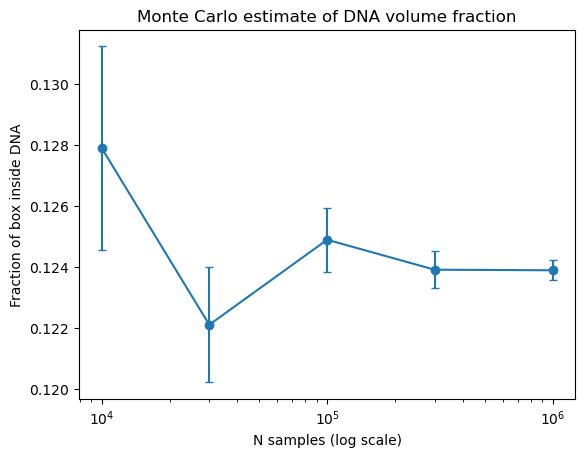

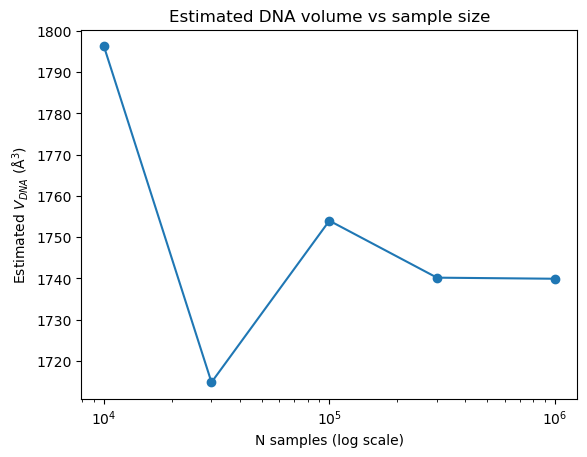

In [13]:
rng = np.random.default_rng(123)

# Sample sizes to see convergence
Ns = [10_000, 30_000, 100_000, 300_000, 1_000_000]
fractions = []
errors = []

for N in Ns:
    frac, err = estimate_fraction_inside_spheres(dna_box, dna_spheres, n_samples=N, rng=rng)
    fractions.append(frac)
    errors.append(err)

# DNA volume estimate = fraction * box volume
dna_box_vol = dna_box.volume()
dna_vol_estimates = [f * dna_box_vol for f in fractions]

print(f"Simulation box volume: {dna_box_vol:.3e} Å^3\n")

for N, f, se, v in zip(Ns, fractions, errors, dna_vol_estimates):
    print(
        f"N={N:8d}  fraction={f:.6e}  stderr≈{se:.6e}  "
        f"V_DNA≈{v:.0f} Å^3"
    )

# Plot fraction vs N (and/or volume vs N)
plt.figure()
plt.errorbar(Ns, fractions, yerr=errors, fmt="o-", capsize=3)
plt.xscale("log")
plt.xlabel("N samples (log scale)")
plt.ylabel("Fraction of box inside DNA")
plt.title("Monte Carlo estimate of DNA volume fraction")
plt.show()

plt.figure()
plt.plot(Ns, dna_vol_estimates, "o-")
plt.xscale("log")
plt.xlabel("N samples (log scale)")
plt.ylabel(r"Estimated $V_{DNA}$ (Å$^3$)")
plt.title("Estimated DNA volume vs sample size")
plt.show()

# TOPIC 2: Random Walk for Accessible Volume Calculation

## Task 1: Make a function to generate a set of random walkers in 3d starting from a set of different random

traj shape: (50, 501, 3)
Assertion checks passed: shapes OK and all points inside the box.


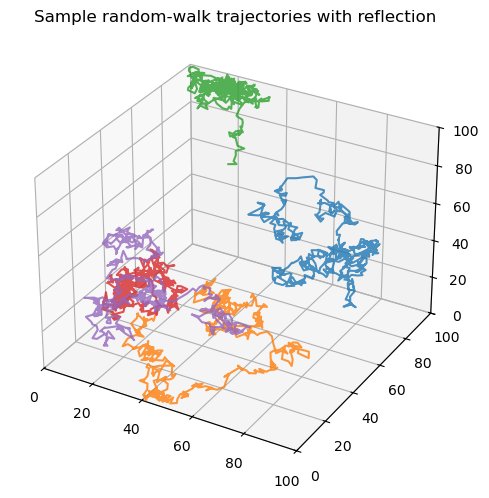

In [31]:
# Basic parameters
num_walkers = 50
num_steps   = 500
step_sigma  = 1.5

traj = random_walkers_3D(box, num_walkers=num_walkers, num_steps=num_steps, step_sigma=step_sigma)
print("traj shape:", traj.shape)  # (W, T+1, 3)

# Shape assertion checks
assert traj.shape == (num_walkers, num_steps + 1, 3)

# All points inside box assertion checks
xmin, xmax = box.xmin, box.xmax
ymin, ymax = box.ymin, box.ymax
zmin, zmax = box.zmin, box.zmax
assert np.all((traj[...,0] >= xmin) & (traj[...,0] <= xmax))
assert np.all((traj[...,1] >= ymin) & (traj[...,1] <= ymax))
assert np.all((traj[...,2] >= zmin) & (traj[...,2] <= zmax))

print("Assertion checks passed: shapes OK and all points inside the box.")

# Show a set of random walkers with plotting
subset = traj[:5]  # plot a few
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection="3d")

for w in range(subset.shape[0]):
    ax.plot(subset[w,:,0], subset[w,:,1], subset[w,:,2], alpha=0.8)

ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax); ax.set_zlim(zmin, zmax)
ax.set_title("Sample random-walk trajectories with reflection")
plt.tight_layout()
plt.show()

## Task 2: Make a fast function to generate a set of random walkers in 3d starting from a set of different random points

Assert checks on shape and boundary ok!
Assert checks on shape and boundary ok!
SLOW: 0.341s  |  FAST: 0.040s  | shape=(200, 2001, 3)
Slow and fast trajectories match!


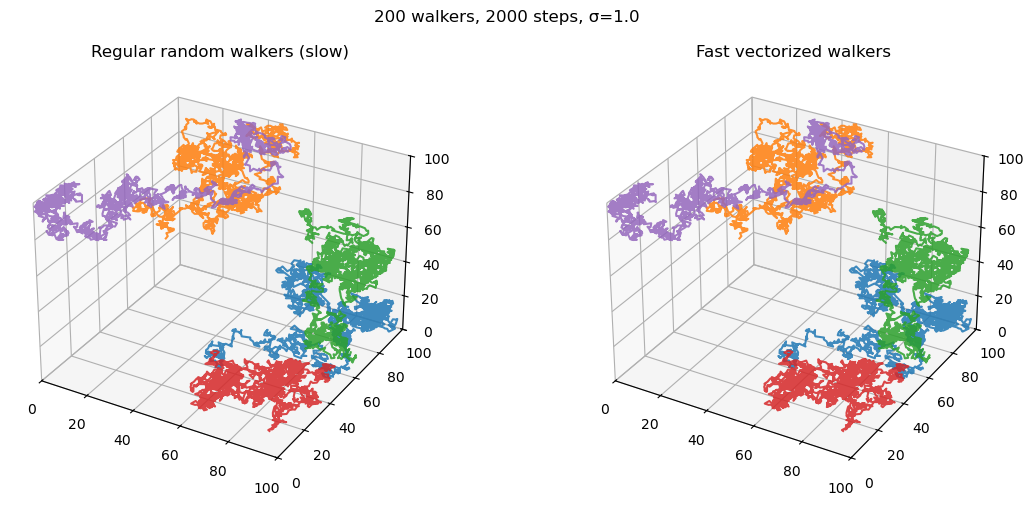

In [59]:
# Parameters
num_walkers, num_steps, step_sigma, seed = 200, 2000, 1.0, 42

rng_steps = np.random.default_rng(seed + 1)
shared_steps = rng_steps.normal(0.0, step_sigma, size=(num_walkers, num_steps, 3))

# run + report
res = run_walkers_slow_fast(box, num_walkers, num_steps, step_sigma, steps=shared_steps, seed=seed)
print(f"SLOW: {res['time_slow']:.3f}s  |  FAST: {res['time_fast']:.3f}s  "
      f"| shape={res['traj_slow'].shape}")

# Check slow and fast subset trajectories match
np.testing.assert_allclose(res["traj_slow"], res["traj_fast"], atol=1e-12)
print("Slow and fast trajectories match!")

# plot subset
plot_walkers_subset(res["traj_slow"], res["traj_fast"], box, subset=5,
                    title=f"{num_walkers} walkers, {num_steps} steps, σ={step_sigma}")

## Task 3: Strategy for Accessible Volume

- Describe your strategy in Markdown here (no code required).
- You can later call your implemented functions to carry it out.

## Task 4: Validation Test

- Describe a test to verify your strategy gives plausible results.
- You can include a simple quantitative bound or comparison approach.

## Task 5: Code & Test Your Approach

In [26]:
# TODO: Run your accessible-volume experiment
# results = run_accessible_volume_experiment(...)
# print(results)
# Optional: plot summaries
pass

## Summary / Reflection

### Amund Brevik

This topic helped me better understand how Monte Carlo methods can be used to estimate quantities that are difficult to compute analytically.
I learned how to use uniformly distributed random points, perform inclusion checks for 3D objects, and combined these techniques to approximate the volume of DNA molecule.
I also gained practice in building modular Python code — using classes, dataclasses, and helper functions — that can be reused later for simulating more complex systems. This part is the most useful for myself and the part that I enjoy the most learning.

I worked on all parts of and focused mostly on topic 1, whereas Espen focused on topic 2, but it is difficult to quantify the work as both me and Espen went over each others work and improved on them whenever possible.

For the AI-usage we only used it as a helper and explainer instead of copy pasting straight from it. VScode also has a built in autocomplete function that I sometimes used for the more simple code segments(repeating code) and comments.
